In [90]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd

In [94]:
figname = 'PaperPlots/14AC_Unmasked_AI_CorrErr.png'

paths = [
#    '/global/cfs/projectdirs/desi/users/lennesse/DR14_Full/Correlations/cf_z_0_10-exp.fits.gz', #No BALs, maroon
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI0/Correlations/cf_z_0_10-exp.fits.gz', #NoBALs
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI25/Correlations/cf_z_0_10-exp.fits.gz', # 25, lightskyblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI50/Correlations/cf_z_0_10-exp.fits.gz', # 50, dodgerblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI75/Correlations/cf_z_0_10-exp.fits.gz', # 75, royalblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI100/Correlations/cf_z_0_10-exp.fits.gz', # All BALs, blue
    #'/global/cscratch1/sd/lennesse/MoreMasking/ai100/Correlations/cf_z_0_10-exp.fits.gz', # All BALs, blue
#    '/global/cfs/projectdirs/desi/users/lennesse/DR14_BAL_AI/Correlations/cf_z_0_10-exp.fits.gz' #All BALs, blue
#    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai25/Correlations/cf_z_0_10-exp.fits.gz',
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai50/Correlations/cf_z_0_10-exp.fits.gz',
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai75/Correlations/cf_z_0_10-exp.fits.gz',
#    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai100/Correlations/cf_z_0_10-exp.fits.gz'
]

paths_somemasking = [
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI0/Correlations/cf_z_0_10-exp.fits.gz', #NoBALs
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI25/Correlations/cf_z_0_10-exp.fits.gz', # 25, lightskyblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI50/Correlations/cf_z_0_10-exp.fits.gz', # 50, dodgerblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI75/Correlations/cf_z_0_10-exp.fits.gz', # 75, royalblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI100/Correlations/cf_z_0_10-exp.fits.gz', # All BALs, blue
]

paths_allmasking = [
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI0/Correlations/cf_z_0_10-exp.fits.gz', #NoBALs
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai25/Correlations/cf_z_0_10-exp.fits.gz',
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai50/Correlations/cf_z_0_10-exp.fits.gz',
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai75/Correlations/cf_z_0_10-exp.fits.gz',
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai100/Correlations/cf_z_0_10-exp.fits.gz'
    
]

paths_compareMasking = [
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI0/Correlations/cf_z_0_10-exp.fits.gz', #NoBALs
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI75/Correlations/cf_z_0_10-exp.fits.gz', # 75, royalblue
    '/global/cscratch1/sd/lennesse/AI_CatalogTests/AI100/Correlations/cf_z_0_10-exp.fits.gz', # All BALs, blue
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai75/Correlations/cf_z_0_10-exp.fits.gz',
    '/global/cscratch1/sd/lennesse/DR14_BAL_Masking/ai100/Correlations/cf_z_0_10-exp.fits.gz'
    
]

colors_blue = [mcd.CSS4_COLORS['maroon'],mcd.CSS4_COLORS['lightskyblue'],mcd.CSS4_COLORS['dodgerblue'],mcd.CSS4_COLORS['royalblue'],mcd.CSS4_COLORS['blue']]
colors = [mcd.CSS4_COLORS['maroon'],mcd.CSS4_COLORS['lightskyblue'],mcd.CSS4_COLORS['dodgerblue'],mcd.CSS4_COLORS['royalblue'],mcd.CSS4_COLORS['blue']]
#names=['','25% BALs','50% BALs','75% BALs','All BALs']
names=['','AI<250','AI<839','AI<2221','All AI values']
#names=['','AI<839, old','AI<2221, old','AI<839, new','AI<2221, new']

In [92]:
def getlabel(wedge,sign) :
        if rp_sign>0 :
                return "$%3.2f<\mu<%3.2f$"%(wedge[0],wedge[1])
        else :
                return "$%3.2f<\mu<%3.2f$"%(-wedge[1],-wedge[0])

In [93]:
def read_baofit_fits(filename) :
    #if filename.find(".fits.gz")<0 :
    #    print("error need a fits file")
    h=fits.open(filename)
    rp=h[1].data["RP"]
    rt=h[1].data["RT"]
    d=h[1].data["DA"]
    c=h[1].data["CO"]
    nb=h[1].data["NB"]
    print(nb.size)
    return rp,rt,d,c,nb

In [84]:
def block(covmat,indices) :
    res=np.zeros((indices.size,indices.size))
    for i in range(indices.size) :
        res[i,:]=covmat[indices[i],indices]
    return res

def compute_wedge(rp,rt,input_xi2d,input_cov,input_nb,murange=[0.8,1.0],rrange=[10,180],rbin=4,rpmin=None,beta=0,rpmax=None) : 
    
    orp=rp.copy()
    rp=np.abs(rp)
    
    # indexing
    rstep = rt[1]-rt[0]
    #print("rstep=",rstep)
    rr=np.sqrt(rt**2+rp**2)
        
    rt_edges=np.zeros((rt.size,2,2))
    rp_edges=np.zeros((rp.size,2,2))
    for i in range(2) :
        for j in range(2) :
            rt_edges[:,i,j]=rt[:]-rstep/2.+i*rstep
            rp_edges[:,i,j]=rp[:]-rstep/2.+j*rstep
    #print(rp_edges)
    rr_edges=np.sqrt(rt_edges**2+rp_edges**2)
    #print(rr_edges)
    mu_edges=rp_edges/(rr_edges+(rr_edges==0))
    
    rr_min=np.min(np.min(rr_edges,axis=-1),axis=-1)
    rr_max=np.max(np.max(rr_edges,axis=-1),axis=-1)
    mu_min=np.min(np.min(mu_edges,axis=-1),axis=-1)
    mu_max=np.max(np.max(mu_edges,axis=-1),axis=-1)
    
    nr=int((rrange[1]-rrange[0])/rbin)
    r=rrange[0]+rbin/2+np.arange(nr)*rbin

    #select indicies in mu wedge
    selection = (mu_max>=murange[0])&(mu_min<=murange[1])&(rr_max>=rrange[0])&(rr_min<=rrange[1])
    if rpmin is not None : selection &= (orp>rpmin)
    if rpmax is not None : selection &= (orp<rpmax)
    wedge_indices=np.where(selection)[0]
    wedge_data=input_xi2d[wedge_indices]
    rr=rr[wedge_indices] #not used again
    rt=rt[wedge_indices]
    rp=rp[wedge_indices]
    rr_edges=rr_edges[wedge_indices] #not used again
    mu_edges=mu_edges[wedge_indices] #not used again
    rr_min=rr_min[wedge_indices]
    rr_max=rr_max[wedge_indices]
    mu_min=mu_min[wedge_indices]
    mu_max=mu_max[wedge_indices]
        
    ndata=wedge_data.size
    wedge_cov=block(input_cov,wedge_indices)
    
    wedge_nb=input_nb[wedge_indices]
    
    var=np.diag(wedge_cov)

    H=np.zeros((nr,ndata))
    H_nb=np.zeros((nr,ndata))
    for i in range(nr) :
        rmin=r[i]-rbin/2.
        rmax=r[i]+rbin/2.
        jj=np.where((mu_max>=murange[0])&(mu_min<=murange[1])&(rr_max>=rmin)&(rr_min<=rmax))[0]
        for j in jj :
            # find fraction of each pixel in slice rmin,rmax,mu_min,mu_max with subsampling pixel
            n=7
            rtb=np.tile(np.linspace(rt[j]-rstep/2.+rstep/n/2,rt[j]+rstep/2.-rstep/n/2.,n),(n,1)).ravel()
            rpb=np.tile(np.linspace(rp[j]-rstep/2.+rstep/n/2,rp[j]+rstep/2.-rstep/n/2.,n),(n,1)).T.ravel()
            rrb=np.sqrt(rtb**2+rpb**2)
            mub=rpb/rrb
            H[i,j]=np.sum((mub>=murange[0])*(mub<=murange[1])*(rrb>=rmin)*(rrb<rmax)*(1+beta*mub**2)**2)/var[j] # weight with mu is beta>0
            H_nb[i,j]=np.sum((mub>=murange[0])*(mub<=murange[1])*(rrb>=rmin)*(rrb<rmax)*(1+beta*mub**2)**2)
        s=np.sum(H[i])
        if s>0 :
            H[i] /= s

    res_nb=H_nb.dot(wedge_nb)
    res=H.dot(wedge_data)
    cov=H.dot(wedge_cov.dot(H.T))
    return r,res,np.sqrt(np.diag(cov).copy()),cov,res_nb

In [110]:
data = []
nb = []
cov = []
rp = []
rt = []

In [111]:
paths = paths_allmasking
for i,path in enumerate(paths):
    trp,trt,d,c,numb = read_baofit_fits(path)
    if abs == True:
        trp = np.abs(trp)
    data.append(d)
    cov.append(c)
    nb.append(numb)
    rp.append(trp)
    rt.append(trt)


2500
2500
2500
2500
2500


In [97]:
def data_loop(data,cov,rp,rt,nb,rp_sign,wedge,rrange=[10,180],rpower=2):
    xidata_array={}
    ximod_array={}
    cov_array={}
    xierr={}
    r={}
        
    label = getlabel(wedge,rp_sign)
    full_label = label
    subsample=np.where(rp_sign*rp>=0)[0]

    r,xidata,xierr,wedge_cov,nb_r=compute_wedge(rp[subsample],rt[subsample],data[subsample],block(cov,subsample),nb[subsample],murange=wedge,rrange=rrange,rbin=4.0,rpmin=None,beta=0,rpmax=None)
    xidata_array[label] = xidata

    cov_array[label] = wedge_cov
    scale=r**rpower
    
    return xierr,r,nb_r,xidata

In [112]:
wedges= [[0.95,1.0],[0.8,0.95],[0.5,0.8],[0.0,0.5]]
nw=len(wedges)
sign=""
label="$%s\\xi(r)$"%sign

abs_rp=True
has_neg_rp= np.sum(rp[0]<0)>0
rp_signs=[]
if has_neg_rp and abs_rp :
    rp_signs=[1,-1]
else :
    rp_signs=[1]
    
ncols=int(np.sqrt(nw))
nrows=nw//ncols
if ncols*nrows < nw : nrows += 1
ax = {}
ncols=int(np.sqrt(nw))
nrows=nw//ncols
if ncols*nrows < nw : nrows += 1

Errors

[  2017826   5512361   9382819 ... 265861815 271082554 276991477]
[  2017826   5512361   9382819 ... 265861815 271082554 276991477]
[  2017826   5512361   9382819 ... 265861815 271082554 276991477]
[  2017826   5512361   9382819 ... 265861815 271082554 276991477]


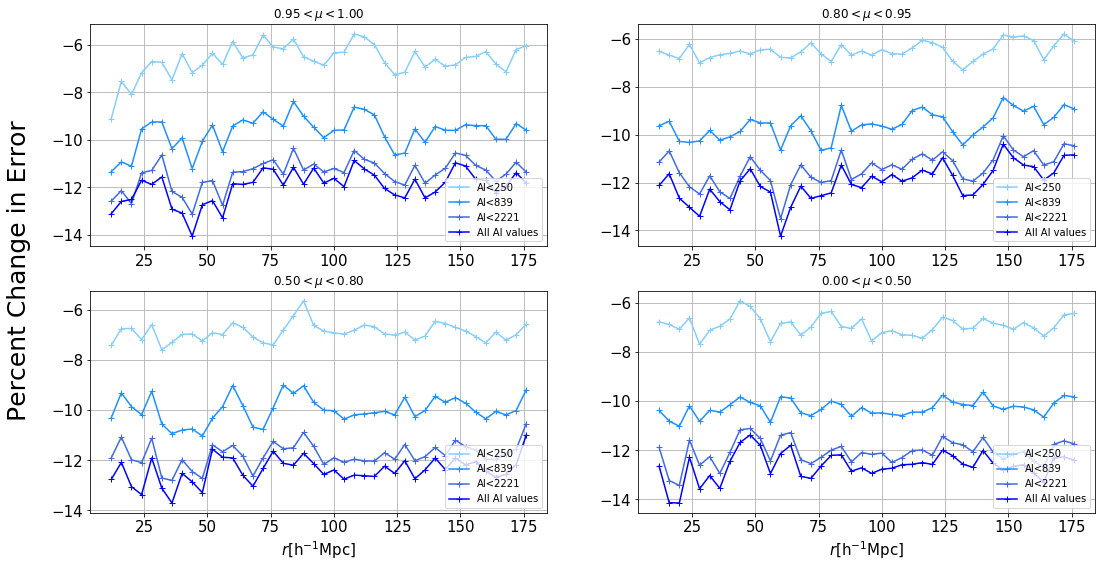

In [113]:
fig = plt.figure(figsize=(18,9))

colors = colors_blue
#markers = ['^','^','+','+']
#colors = [mcd.CSS4_COLORS['maroon'],mcd.CSS4_COLORS['royalblue'],mcd.CSS4_COLORS['blue'],mcd.CSS4_COLORS['royalblue'],mcd.CSS4_COLORS['blue']]
#names=['','AI<2221, LyA, N5 masking only','All BALs, LyA, N5 masking only','AI<2221, all masking', 'All BALs, all masking']

for index in range(1,nw+1) :
    ax[index-1] = plt.subplot(nrows,ncols,index)

for w,wedge in zip(range(nw),wedges):
    
    for rp_sign in rp_signs:
        print(nb[0])
        ##First Data
        err0,r,nb0,corr0 = data_loop(data[0],cov[0],rp[0],rt[0],nb[0],rp_sign,wedge)
    
        #Second Data
        for i in range(len(paths)-1):
            err,r,nb_r,corr = data_loop(data[i+1],cov[i+1],rp[i+1],rt[i+1],nb[i+1],rp_sign,wedge)
            corrDiff = (err/err0 - 1)*100
            ax[w].plot(r,corrDiff,marker='+', color=colors[i+1], label=names[i+1])

        ax[w].tick_params(axis='both', which='major', labelsize=15)
        ax[w].set_title(getlabel(wedge,rp_sign))
        ax[w].grid(b=True)
        ax[w].legend(fontsize=10,numpoints=1,loc="lower right")

for i in range(nw-ncols,nw):
    ax[i].set_xlabel(r"$r\mathrm{[h^{-1}Mpc]}$", fontsize=15)
    
label = 'Percent Change in Error'
    
fig.text(0.07, 0.5, label, ha='center', va='center', rotation='vertical',fontsize=25)

figname = 'PaperPlots/CorrErrors_AllMasking'
plt.savefig(figname,bbox_inches='tight')

NBPix/point

Text(0.07,0.5,'Percent Change')

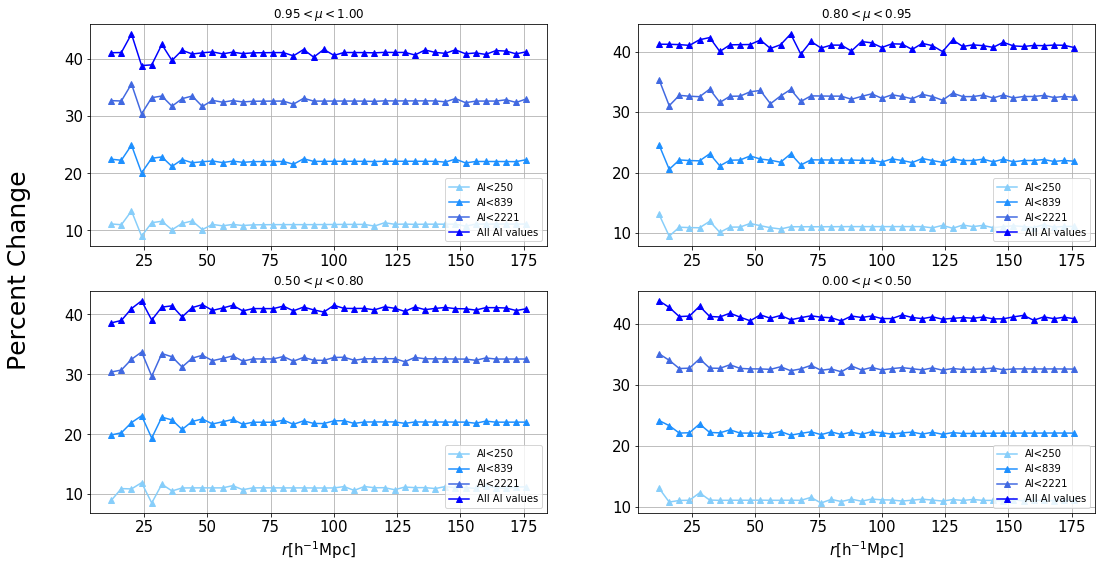

In [108]:
fig = plt.figure(figsize=(18,9))
    
for index in range(1,nw+1) :
    ax[index-1] = plt.subplot(nrows,ncols,index)

for w,wedge in zip(range(nw),wedges):
    
    for rp_sign in rp_signs:
        ##First Data
        err0,r,nb0,corr0 = data_loop(data[0],cov[0],rp[0],rt[0],nb[0],rp_sign,wedge)
    
        #Second Data
        for i in range(len(paths)-1):
            err,r,nb_r,corr = data_loop(data[i+1],cov[i+1],rp[i+1],rt[i+1],nb[i+1],rp_sign,wedge)
            nbDiff = (nb_r/nb0 - 1)*100
            ax[w].plot(r,nbDiff,marker="^", color=colors[i+1], label=names[i+1])

        ax[w].tick_params(axis='both', which='major', labelsize=15)
        ax[w].set_title(getlabel(wedge,rp_sign))
        ax[w].grid(b=True)
        ax[w].legend(fontsize=10,numpoints=1,loc="lower right")

for i in range(nw-ncols,nw):
    ax[i].set_xlabel(r"$r\mathrm{[h^{-1}Mpc]}$", fontsize=15)
    
label = 'Percent Change'
    
fig.text(0.07, 0.5, label, ha='center', va='center', rotation='vertical',fontsize=25)

#plt.savefig(figname,bbox_inches='tight')

[  2017826   5512361   9382819 ... 265861815 271082554 276991477]
[  2017826   5512361   9382819 ... 265861815 271082554 276991477]
[  2017826   5512361   9382819 ... 265861815 271082554 276991477]
[  2017826   5512361   9382819 ... 265861815 271082554 276991477]


Text(0.07,0.5,'Percent Change')

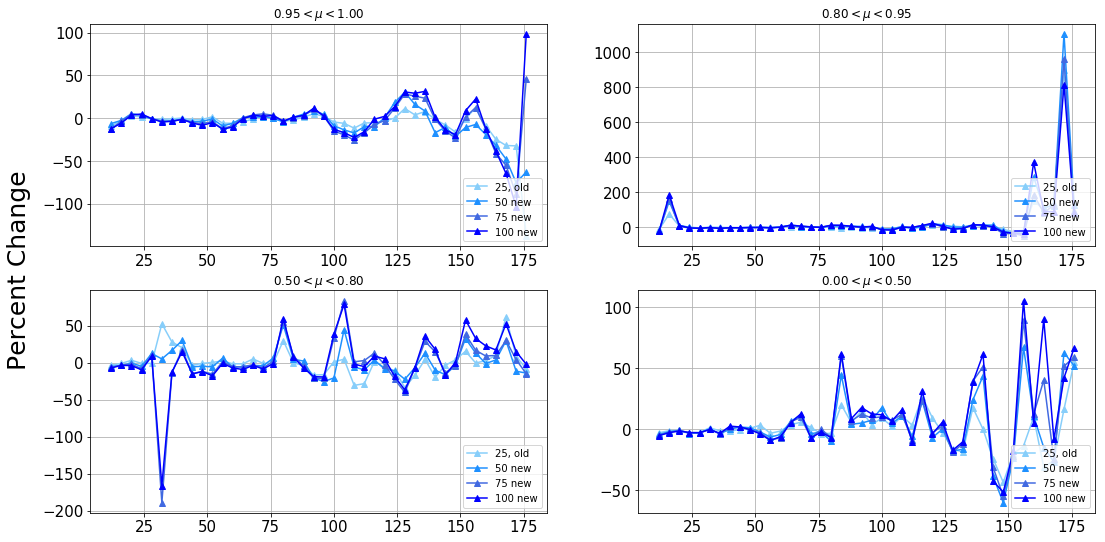

In [15]:
fig = plt.figure(figsize=(18,9))
    
for index in range(1,nw+1) :
    ax[index-1] = plt.subplot(nrows,ncols,index)

for w,wedge in zip(range(nw),wedges):
    
    for rp_sign in rp_signs:
        print(nb[0])
        ##First Data
        err0,r,nb0,corr0 = data_loop(data[0],cov[0],rp[0],rt[0],nb[0],rp_sign,wedge)
    
        #Second Data
        for i in range(len(paths)-1):
            err,r,nb_r,corr = data_loop(data[i+1],cov[i+1],rp[i+1],rt[i+1],nb[i+1],rp_sign,wedge)
            corrDiff = (corr/corr0 - 1)*100
            ax[w].plot(r,corrDiff,marker="^", color=colors[i+1], label=names[i+1])

        ax[w].tick_params(axis='both', which='major', labelsize=15)
        ax[w].set_title(getlabel(wedge,rp_sign))
        ax[w].grid(b=True)
        ax[w].legend(fontsize=10,numpoints=1,loc="lower right")

#for i in range(nw-ncols,nw):
#    ax[i].set_xlabel(r"$r\mathrm{[h^{-1}Mpc]}$", fontsize=15)
    
label = 'Percent Change'
    
fig.text(0.07, 0.5, label, ha='center', va='center', rotation='vertical',fontsize=25)

#plt.savefig(figname,bbox_inches='tight')

Size of Error vs. num of qsos

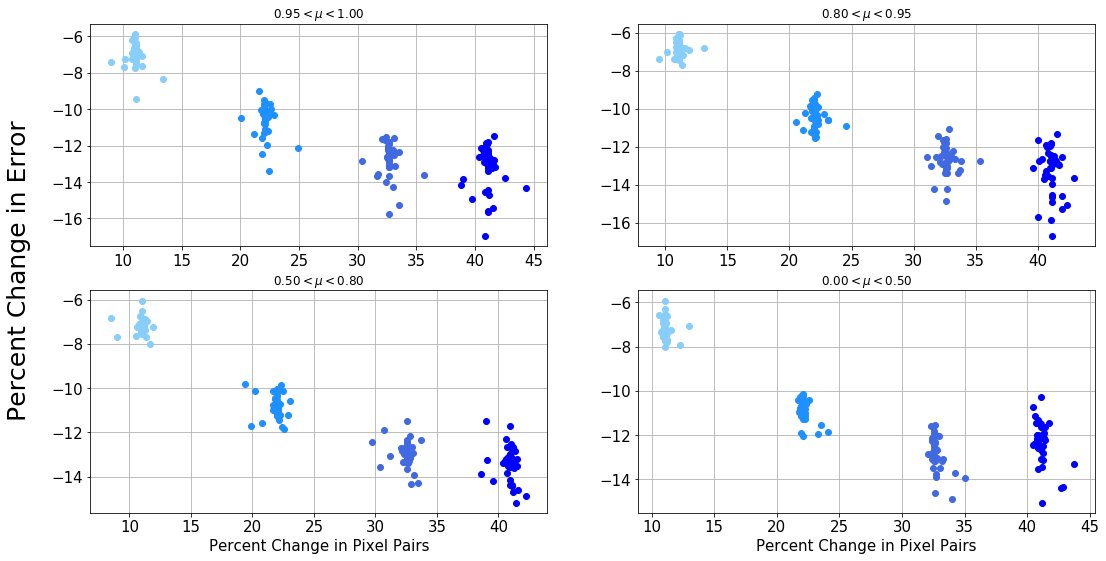

In [107]:
fig = plt.figure(figsize=(18,9))
    
for index in range(1,nw+1) :
    ax[index-1] = plt.subplot(nrows,ncols,index)

for w,wedge in zip(range(nw),wedges):
    
    for rp_sign in rp_signs:
        ##First Data
        err0,r,nb0,corr0 = data_loop(data[0],cov[0],rp[0],rt[0],nb[0],rp_sign,wedge)
    
        #Second Data
        for i in range(len(paths)-1):
            err,r,nb_r,corr = data_loop(data[i+1],cov[i+1],rp[i+1],rt[i+1],nb[i+1],rp_sign,wedge)
            errDiff = (err/err0 - 1)*100
            nbDiff = (nb_r/nb0 -1)*100
            ax[w].plot(nbDiff,errDiff,marker="o", color=colors[i+1], label=names[i+1], linestyle='None')
        ax[w].tick_params(axis='both', which='major', labelsize=15)
        ax[w].set_title(getlabel(wedge,rp_sign))
        ax[w].grid(b=True)
        #ax[w].legend(fontsize=10,numpoints=1,loc="upper right")

for i in range(nw-ncols,nw):
    ax[i].set_xlabel(r"Percent Change in Pixel Pairs", fontsize=15)
    
label = 'Percent Change in Error'
    
fig.text(0.07, 0.5, label, ha='center', va='center', rotation='vertical',fontsize=25)
figname = 'PaperPlots/Err_vs_PP_NVLYAOnlyMasking.png'

plt.savefig(figname,bbox_inches='tight')